✅ Using device: mps
🔄 모델 학습 시작...
Epoch [1/10], Step [100/938], Loss: 0.8771
Epoch [1/10], Step [200/938], Loss: 0.3368
Epoch [1/10], Step [300/938], Loss: 0.2804
Epoch [1/10], Step [400/938], Loss: 0.2562
Epoch [1/10], Step [500/938], Loss: 0.2054
Epoch [1/10], Step [600/938], Loss: 0.2067
Epoch [1/10], Step [700/938], Loss: 0.1881
Epoch [1/10], Step [800/938], Loss: 0.1722
Epoch [1/10], Step [900/938], Loss: 0.1619
Epoch [2/10], Step [100/938], Loss: 0.1300
Epoch [2/10], Step [200/938], Loss: 0.1327
Epoch [2/10], Step [300/938], Loss: 0.1200
Epoch [2/10], Step [400/938], Loss: 0.1227
Epoch [2/10], Step [500/938], Loss: 0.1129
Epoch [2/10], Step [600/938], Loss: 0.1155
Epoch [2/10], Step [700/938], Loss: 0.0971
Epoch [2/10], Step [800/938], Loss: 0.1111
Epoch [2/10], Step [900/938], Loss: 0.1144
Epoch [3/10], Step [100/938], Loss: 0.0890
Epoch [3/10], Step [200/938], Loss: 0.0882
Epoch [3/10], Step [300/938], Loss: 0.0943
Epoch [3/10], Step [400/938], Loss: 0.0845
Epoch [3/10], Step [

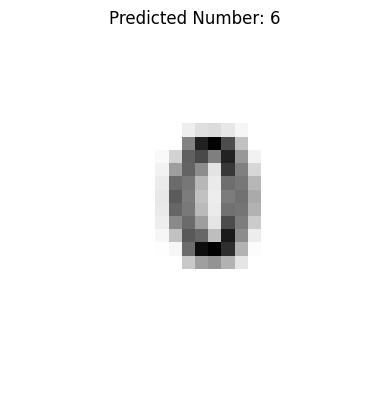

🔍 예측된 숫자: 6


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image

# 🔹 MPS 사용 가능 여부 확인
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"✅ Using device: {device}")

# 데이터 로딩
transform = transforms.Compose([transforms.ToTensor()])
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# CNN 모델 정의
class BasicCNN(nn.Module):
    def __init__(self):
        super(BasicCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16 * 14 * 14, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = x.view(-1, 16 * 14 * 14)
        x = self.fc1(x)
        return x

# 모델 및 학습 설정
model = BasicCNN().to(device)  # 모델을 GPU로 전송
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 🔹 CNN 모델 학습 (손실 함수 확인 + 모델 저장)
num_epochs = 10  # 여러 번 학습 가능
save_path = "./mnist_cnn.pth"

print("🔄 모델 학습 시작...")
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (images, labels) in enumerate(trainloader):
        images, labels = images.to(device), labels.to(device)  # 데이터를 GPU로 전송

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # 100번마다 손실값 출력
        if (i + 1) % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(trainloader)}], Loss: {running_loss / 100:.4f}")
            running_loss = 0.0

# 학습 완료 후 모델 저장
torch.save(model.state_dict(), save_path)
print(f"✅ 모델이 저장되었습니다: {save_path}")


# 🔹 저장된 모델 불러오기
def load_model(model_path):
    model = BasicCNN()
    model.load_state_dict(torch.load(model_path))
    model.to(device)  # 모델을 GPU로 전송
    model.eval()
    return model

# 🔹 숫자 이미지 파일을 모델에 입력하여 예측하는 함수
def predict_digit(image_path, model):
    """
    사용자가 제공한 숫자 이미지 파일을 불러와 CNN 모델을 통해 예측하는 함수.
    """
    # 이미지 불러오기 및 전처리
    image = Image.open(image_path).convert("L")  # 흑백 변환
    transform = transforms.Compose([
        transforms.Resize((28, 28)),  # MNIST 크기로 조정
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))  # 정규화
    ])

    image = transform(image).unsqueeze(0).to(device)  # 배치 차원 추가 및 GPU로 전송

    # 모델 예측
    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)

    # 결과 출력
    plt.imshow(image.cpu().squeeze(), cmap="gray")  # 이미지를 CPU로 이동 후 시각화
    plt.title(f"Predicted Number: {predicted.item()}")
    plt.axis('off')
    plt.show()

    print(f"🔍 예측된 숫자: {predicted.item()}")

# ✅ 저장된 모델 불러오기
loaded_model = load_model("./mnist_cnn.pth")

# 🏆 샘플 이미지 예측 실행 (예: "digit.png" 파일 입력)
predict_digit("digit_0.png", loaded_model)